# Group information

Names:

Felipe Scalabrin Dosso

Gabriel Cunha Marchetti

RAs:

236110

251055

## Objective:

To explore **Transfer Learning** techniques, focused on **Transformers**. In this task you'll be visualizing and fine tunning a pre trained transformer to a Natural Language Processing task, specifically, binary sentiment classification.

This **MUST** be developed using the pytorch and the [Hugging Face](https://huggingface.co/) library.

## Dataset

The dataset you will use is the "Large Movie Review Dataset", also known as IMDB dataset. This dataset contains 50000 movie reviews, with positive or negative labels. The dataset is balanced, and the train and test sets are already separated in a disjointed way, to avoid movies being in both datasets (as reviews in the same movies tend to be similar).

The labels are constructed using the ratings of the review, where a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. "Neutral" reviews (score 5 or 6) were ignored, as they cannot be correctly labeled between negative and positive samples.


The dataset will be available in the [same folder](https://drive.google.com/drive/folders/14uiy_7xMq5LOqODBzbIJLD4Vq0E9XD5v) as the other tasks, in the "aclImdb" folder. You can copy the dataset folder or download it locally.

Here are some examples of each class from the dataset:

**Negative**

`Lifetime did it again. Can we say stupid? I couldn't wait for it to end. The plot was senseless. The acting was terrible! Especially by the teenagers. The story has been played a thousand times! Are we just desperate to give actors a job? The previews were attractive and I was really looking for a good thriller.Once in awhile lifetime comes up with a good movie, this isn't one of them. Unless one has nothing else to do I would avoid this one at all cost. This was a waste of two hours of my life. Can I get them back? I would have rather scraped my face against a brick wall for two hours then soaked it in peroxide. That would have been more entertaining.`

**Positive**

`Generally it was a good movie with an ideal ending; the acting was spectacular and the characters didn't stray from their persons. I especially liked the plot, although you knew what was going to happen it still gave the element of surprise through out the entire movie. However, I find that coming on to the ending it could have been a little longer (extended maybe)- to me it seemed like it was rushed a bit; as if the writer was trying to take linens off the lines before the rain fell. For instance- What happened to Tristan's brother, Hayden? For all we know he died in the hospital. Maybe he was the one that setup the entire thing?! Who knows! Maybe there will be a sequel? Maybe? If there is.. I cant wait to see it.`


As in the previous task, in this task the data analysis will not be required. Again, its important to remember that the data analysis is a constant and important part of the machine learning pipeline, and we are just skipping it because this task has educational purposes only.

## Loading the dataset

The code below is already completed to load the dataset separating it in train, validation and test.

In [ ]:
import os
import random
import pandas as pd

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from transformers import BertTokenizerFast, BertForSequenceClassification

In [ ]:
# Define dataset path (remove colab import/mount if running locally)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# set path to the folder that contains the aclImdb dataset
path = "gdrive/MyDrive/MC886-Datasets/"

Mounted at /content/gdrive


In [ ]:
# this separates 20k for training, 5k for validation and 25k for testing

max_valid = 5000

def load_texts(folder):
  texts = []
  for path in os.listdir(folder):
    with open(os.path.join(folder, path)) as f:
      texts.append(f.read())
  return texts

x_train_pos = load_texts(path + 'aclImdb/train/pos')
x_train_neg = load_texts(path + 'aclImdb/train/neg')
x_test_pos  = load_texts(path + 'aclImdb/test/pos')
x_test_neg  = load_texts(path + 'aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test  = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test  = [True] * len(x_test_pos)  + [False] * len(x_test_neg)

c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print('\nFirst two train samples:')
for i, (source, target) in enumerate(zip(x_train[:2], y_train[:2])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print('\nFirst two valid samples:')
for i, (source, target) in enumerate(zip(x_valid[:2], y_valid[:2])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print(f'Train size: {len(x_train)}')
print(f'Valid size: {len(x_valid)}')
print(f'Test size: {len(x_test)}')


First two train samples:
0: Input: Dietrich Bonhoeffer's writings have had a profound influence on my life as a Christian, and I eagerly anticipated watching this movie and finding out more about his life. Words can hardly express my disappointment. This movie was disjointed...it gave no background about his life, no historical context, and nothing about his great writings (except a brief, passing reference to "The Cost of Discipleship" by a colleague at the beginning of the movie.) Instead, we see him enjoying jazz (apparently in the States) and chilling out with his friends before he decides to go back to Germany. Apparently to show his human side. OK, I'm ready for the dramatic part. The part where he stands up for his faith. Instead of emphasizing that, we get a very badly acted romance with a 17-year-old schoolgirl. Whether or not that actually took place, it should not have been a major portion of the movie. Now...still waiting for the dramatic part, or some narration explaining

## Loading the pre trained transformer

The code below loads a pre trained transformer from hugging face library.
The **recommended** model is the BERT-Mini, that is a smaller version of the BERT transformer.

You can choose other transformers to test, but the BERT-Mini was choosed to reduce the fine tunning time, while also having a powerfull structure.

The image below shows the normal BERT architecture scheme and the BERT-Large. In the same way, the BERT-Mini has only four attention heads (instead of the original 12).

![BERTS](https://huggingface.co/blog/assets/52_bert_101/BERT-size-and-architecture.png)

The BERT variations also are related to amount of hidden embedding sizes.
Some variations are:

- google/bert_uncased_L-2_H-128_A-2 (BERT-Tiny, 4M params)
- google/bert_uncased_L-4_H-256_A-4 (BERT-Mini, 11M params)
- google/bert_uncased_L-4_H-512_A-4 (BERT-Small, 29M params)
- google/bert_uncased_L-8_H-512_A-8 (BERT-Medium, 41M params)
- google/bert_uncased_L-12_H-768_A-12 (BERT-Base, 110M params)

You can find more details about miniature BERT versions [here](https://huggingface.co/google/bert_uncased_L-4_H-256_A-4).


## Parameters

In [ ]:
params = {
    'bert_version': "google/bert_uncased_L-4_H-256_A-4",
    'batch_size': 20,
    'learning_rate': 1e-4, # Choose a learning rate between 1e-4 and 1e-7
    'weight_decay': 0.01,  # Choose a value between 1e-2 and 1e-4.
    'max_length': 100,     # The maximum length of the sentence (can be adjusted)
    'epochs': 3,           # Choose a value between 1 and 5
}

## Tokenizer

To use text as input for a deep learning model, we first need to tokenize each sentence based on a set of rules. After tokenization, each token is assigned a correlated index, creating a feature vector. This vector is then utilized by the model to train and update the weights. Here is an example demonstrating how the BERT tokenizer works:

![bert_tokenizer](https://drive.google.com/uc?export=view&id=11LioDFis0JE3ghr672PEIeaAxZO42gUL)

Initially, the input sentence is divided into tokens predetermined by the BERT tokenizer. Next, the BertTokenizer introduces two special tokens: CLS and SEP. CLS represents sentence start for tasks like classification, while SEP indicates sentence separation for boundary detection within a document. Additionally, to ensure sentences are of equal length, the tokenizer employ the PAD token for each input.

Finally, each token is converted into a predetermined index for BERT input. This indexing enables the Bert model to train and update its weights effectively.

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data   = data
        self.labels = torch.Tensor(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.data.items()}
        item['labels'] = self.labels[index]
        return item

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(params['bert_version'], disable_tqdm=False)

## TOKENIZE
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_encodings = tokenizer(list(x_valid), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
test_encodings  = tokenizer(list(x_test),  truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])

## DATASET
train_dataset = IMDBDataset(data=train_encodings, labels=y_train)
valid_dataset = IMDBDataset(data=valid_encodings, labels=y_valid)
test_dataset  = IMDBDataset(data=test_encodings, labels=y_test)

## DATALOADER
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=1)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=params['batch_size'], num_workers=1)
test_loader  = DataLoader(dataset=test_dataset, batch_size=params['batch_size'], num_workers=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Load the transformer


In [ ]:

#defining device where to to the computation
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(params['bert_version'], output_hidden_states=True)
model = model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Dimentionality reduction and visualization tranformer embeddings (3.5 points)

In this section, you should use PCA and t-SNE to visualize the embeddings produced by the transformer for a batch of the aclImdb dataset.

In [ ]:
# Function to visualize the embeddings

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_layerwise_embeddings(hidden_states, masks, labels, layers_to_visualize, dim_reducer):
  '''
  'hidden_states' are the activations of the hidden layers for a batch
    (use the '.hidden_states' attribute from the transformer's output with 'output_hidden_states=True');
  'masks' are the attention masks of each sample (the dataloader returns a dict with the "attention_masks" key);
  'labels' are the labels of the batch;
  'layers_to_visualize' is an array of indexes to look on 'hidden_states';
  'dim_reducer' is a function to reduce the dimentionality of the hidden states (should be PCA or t-SNE object).
  '''
  num_layers = len(layers_to_visualize)

  fig = plt.figure(figsize=(24,int((num_layers/4)*6))) # each subplot of size 6x6, each row will hold 4 plots
  ax = [fig.add_subplot(num_layers//4+1,4,i+1) for i in range(num_layers)]

  labels = labels.numpy().reshape(-1)

  for i,layer_i in enumerate(layers_to_visualize):
    layer_embeds = hidden_states[layer_i].cpu()

    layer_averaged_hidden_states = torch.div(layer_embeds.sum(dim=1),masks.sum(dim=1,keepdim=True))
    layer_dim_reduced_embeds = dim_reducer.fit_transform(layer_averaged_hidden_states.detach().numpy())

    df = pd.DataFrame.from_dict({'x':layer_dim_reduced_embeds[:,0],'y':layer_dim_reduced_embeds[:,1],'label':labels})

    sns.scatterplot(data=df,x='x',y='y',hue='label',ax=ax[i], palette='husl')
  plt.show()


In [ ]:
def get_batch_data(loader, device):
  for batch in loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    return batch

In [ ]:
#Defining the PCA-object from Sklearn, the object demands to use torch
#but i did not understand the tensor from pca_lowrank.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=2)

5


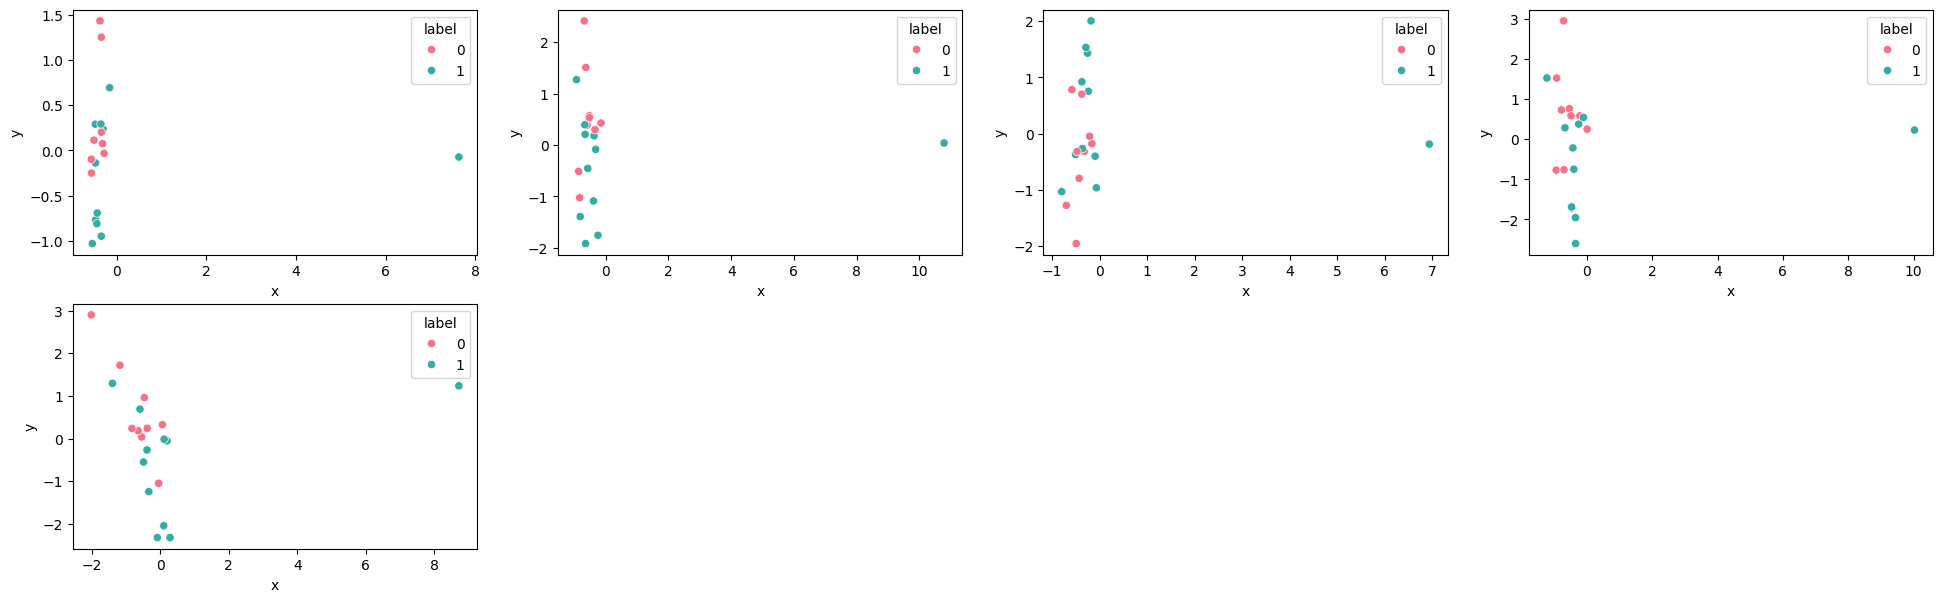

In [ ]:
batch = get_batch_data(train_loader, device)
model.eval()

with torch.no_grad():
  outputs = model(**batch)
  hidden_states = outputs.hidden_states
  masks = batch['attention_mask'].cpu()
  labels = batch['labels'].cpu()

print(len(hidden_states))
# Since we have 4 hidden layers defined by the task.
layers_to_visualize = [0, 1, 2, 3, 4]
pca = PCA(n_components=2)
visualize_layerwise_embeddings(hidden_states, masks, labels, layers_to_visualize, pca)

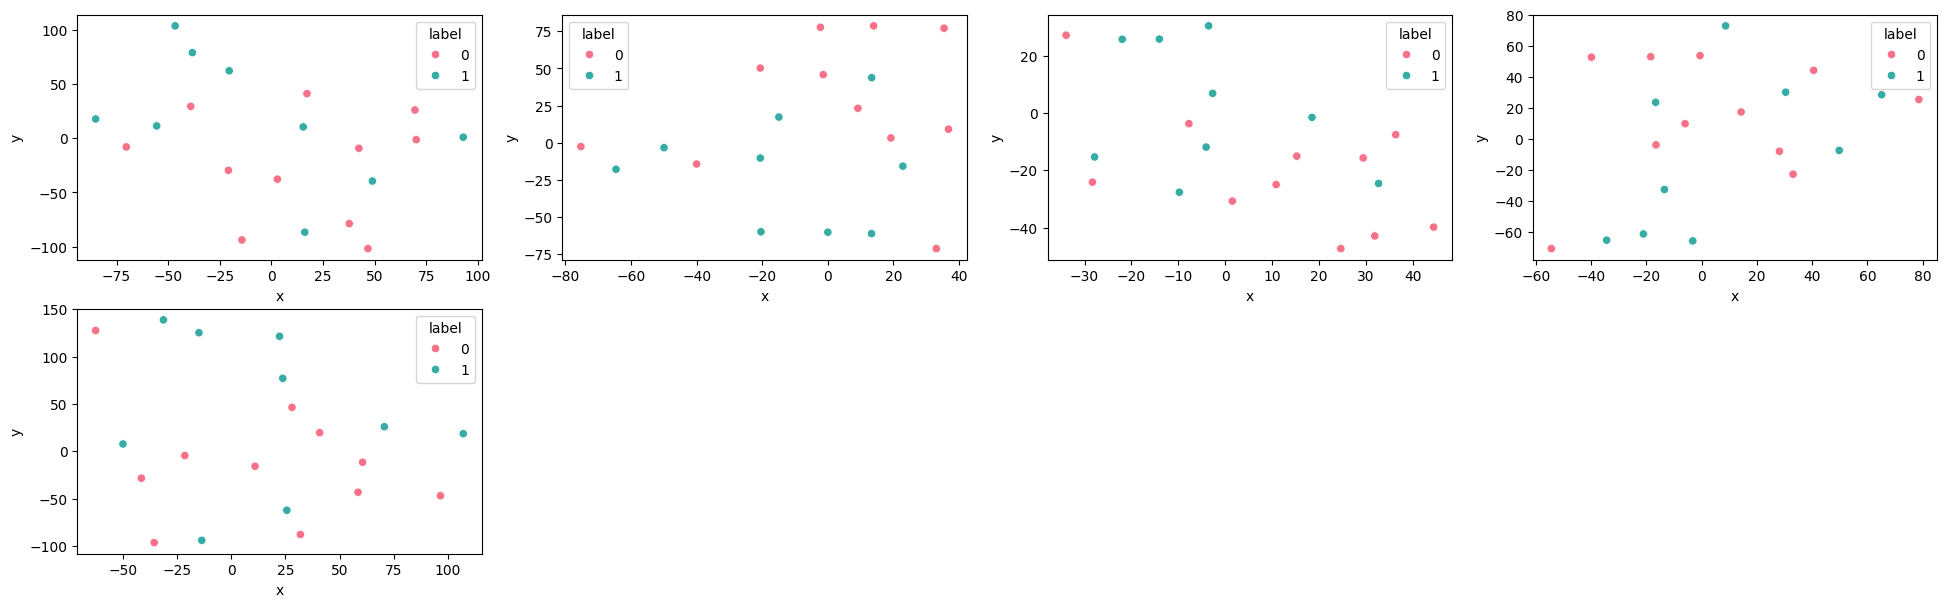

In [ ]:
layers_to_visualize = [0, 1, 2, 3, 4]
# Since batch size is low due to low memory usage by colab, we used
# perplexity 5 since it's the minimum recomended by the documentation
# of Sklearn
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000)

visualize_layerwise_embeddings(hidden_states, masks, labels, layers_to_visualize, tsne)

### Discussion of key points

- The PCA and t-SNE had similar results for the visualization of the embeddings?
- Looking at the best result, this transformer can be used as a Zero-shot* model for this task?


* Zero-shot is the usage a model for a new task without any new traning.

We can see that both PCA and t-SNE had different outputs, we've run multiple examples since the batch size is low and we did get similar results. As we can see above, the PCA performed better to split the data into different areas. Instead, we can see that the t-SNE didn't turn out to be a good predictor for this task.

Even though PCA was better than t-SNE, it did not perform well. But we can see by the disposal of points that the most information is contained just at the first component since we can trace a line to that contains most of the variance.

As we can see we cannot use this model as a Zero-shot since it cannot split well the reviews.


## Fine tune the transformer (5.5 points)

In this section you should fine tune the transformer for the sentiment classification task.

To fine tune a model, we need to "freeze" some of their layers. In this case, we will freeze all trainable parameters, except the last part of the model, which is a fully connected layer called "classifier". You can change this approach and test without freezing the entire transformer, but it is not required.

It is important to pay attention to the learning rate and weight decay of the optimizer. Usually, transformers adapt quickly to the problem, and a wrong learning rate (or number of training epochs) can cause an overfitting.

Work with one epoch and smaller batch sizes to test your implementation, as the training can take a longe time.

Remember to test your final model and plot a confusion matrix with the test data.


In [ ]:
# Freeze all layers of the pre trained model
for i,param in enumerate(model.parameters()):
  param.requires_grad = False

# unfreeze classifier (last layer)
model.classifier.weight.requires_grad = True

In [ ]:
# Define the optmizer, scheduler and criterion

optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay']) # https://pytorch.org/docs/stable/optim.html
# scheduler = # Optional: use a scheduler to control the learning rate (besides the weight_decay of the optimizer)
criterion = torch.nn.CrossEntropyLoss()


### Create the train and validation logic

*Tip: The forward method of the BERT transformer expect the "input_ids" and "attention_masks". You can search about the usage of hugging face transformers on the official documentation [here](https://huggingface.co/docs/transformers/v4.41.3/en/model_doc/bert#transformers.BertForSequenceClassification)*

In [ ]:
def train(model, optimizer, criterion, loader, device):
  '''
  model: it will use the technique of transfer learning. Here we will use the
         BART model pre-defined
  optimizer: define the optimizer of your choice
  criterion: criterion for optimization
  loader: the DataLoader used, here we will use the train_loader
  device: device for running the optimization.
  '''

  # Define the model to train mode.
  model.train()

  train_loss = 0.0
  # Will be used for accuracy
  correct = 0
  total = 0

  # Since we will perform fine tunning
  optimizer.zero_grad()
  for batch in loader:

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss

    #Since we are using cross-entropy
    logits = outputs.logits

    loss.backward()
    optimizer.step()

    # Since we are working with batches
    train_loss += loss.item()
    _, predicted = torch.max(logits, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_acc = correct / total
  train_loss /= len(loader)

  return train_loss, train_acc

def evaluate(model, criterion, loader, device):
  '''
  Almost identical to the train but the loader is the validation loader
  '''

  # Switching model to eval mode
  model.eval()
  valid_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for batch in loader:
      # Move batch to device
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      # Forward pass
      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      logits = outputs.logits

      # Calculate metrics
      valid_loss += loss.item()
      _, predicted = torch.max(logits, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  valid_acc = correct / total
  valid_loss /= len(loader)
  return valid_loss, valid_acc

### Train and validate

In [ ]:
history = {'train_loss': [], 'valid_loss': [], 'train_acc':[], 'valid_acc':[]}

for epoch in tqdm(range(params['epochs']), desc='Training'):
  train_loss, train_acc = train(model, optimizer, criterion, train_loader, device)
  valid_loss, valid_acc = evaluate(model, criterion, valid_loader, device)

  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)

  history['valid_loss'].append(valid_loss)
  history['valid_acc'].append(valid_acc)

Training:   0%|          | 0/3 [00:00<?, ?it/s]

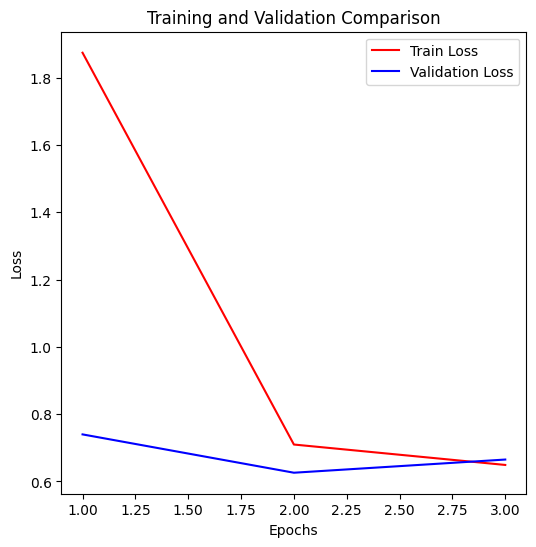

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(6, 6))
plt.plot(epochs, history['train_loss'], label='Train Loss', color='red')
plt.plot(epochs, history['valid_loss'], label='Validation Loss', color='blue')

plt.title('Training and Validation Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

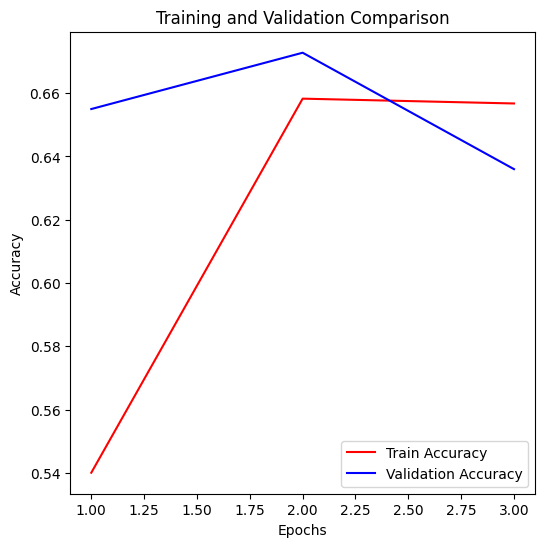

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(6, 6))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', color='red')
plt.plot(epochs, history['valid_acc'], label='Validation Accuracy', color='blue')

plt.title('Training and Validation Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plotting the confusion matrix with the test loader
from sklearn.metrics import confusion_matrix

predictions = []
targets = []

with torch.no_grad():
  for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, predicted = torch.max(outputs.logits, 1)

    predictions.extend(predicted.cpu().numpy())
    targets.extend(labels.cpu().numpy())

cm = confusion_matrix(targets, predictions)

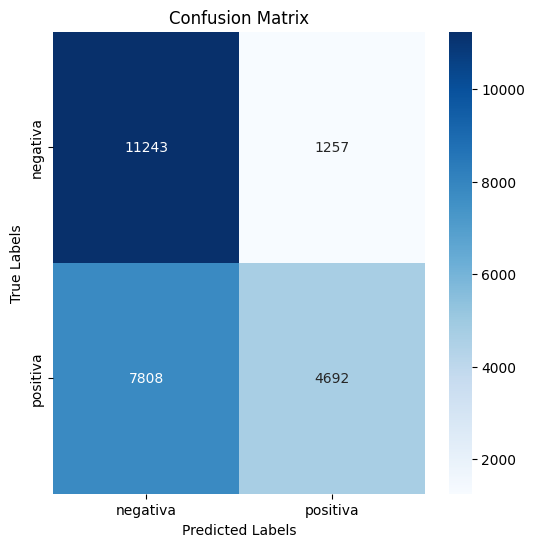

In [ ]:
classes = ['negativa', 'positiva']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import numpy as np
predictions = np.array(predictions)
targets = np.array(targets)
print(np.unique(predictions))
print(np.unique(targets))

[0 1]
[0 1]


In [ ]:
test_acc = ( predictions == targets ).sum()
test_acc = test_acc / len(predictions)
print(f'Accuracy of test: {test_acc}')

Accuracy of test: 0.6374


In [ ]:
# Hand-make tests
def hand_made_test(text):
  inputs = tokenizer(text, return_tensors='pt')
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']

  input_ids = input_ids.to(device)
  attention_mask = attention_mask.to(device)

  model.eval()
  with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, predicted = torch.max(outputs.logits, 1)

  return predicted.cpu().numpy()[0]

In [ ]:
text_input = input()
result = hand_made_test(text_input)
if result == 0:
  print("A análise é negativa.")
else:
  print("A análise é positiva.")

All right
A análise é negativa.


## Visualize transformer embeddings again (1 point)

Use the same logic previously used in the first part of this task to visualize the fine tunned embeddings of the transformer (with PCA and t-SNE).

In [ ]:
def get_batch_data_balanced(loader, device, number):
    positive_data = []
    negative_data = []
    current_pos = 0
    current_neg = 0
    num_positive = number
    num_negative = number

    for batch in loader:
        batch_size = len(batch['input_ids'])
        batch = {k: v.to(device) for k, v in batch.items()}

        labels = batch['labels']
        positive_indices = (labels == 1).nonzero().squeeze(1)
        negative_indices = (labels == 0).nonzero().squeeze(1)

        if current_pos < num_positive:
            positive_to_take = min(num_positive - current_pos, len(positive_indices))
            positive_data.append({k: v[positive_indices[:positive_to_take]] for k, v in batch.items()})
            current_pos += positive_to_take

        if current_neg < num_negative:
            negative_to_take = min(num_negative - current_neg, len(negative_indices))
            negative_data.append({k: v[negative_indices[:negative_to_take]] for k, v in batch.items()})
            current_neg += negative_to_take

        if current_pos >= num_positive and current_neg >= num_negative:
            print('Break condition')
            break



    combined_batch = {}
    for key in positive_data[0].keys():
      combined_batch[key] = torch.cat([b[key] for b in positive_data], dim = 0)

    for key in negative_data[0].keys():
      combined_batch[key] = torch.cat([b[key] for b in negative_data], dim=0)

    # print(positive_data)
    # print(negative_data)
    return combined_batch


In [ ]:
" " "
def get_batch_data_balanced(loader, device, number):
    positive_data = []
    negative_data = []
    current_pos = 0
    current_neg = 0
    num_positive = number
    num_negative = number

    for batch in loader:
        batch_size = len(batch['input_ids'])
        batch = {k: v.to(device) for k, v in batch.items()}

        labels = batch['labels']
        positive_indices = (labels == 1).nonzero(as_tuple=True)[0]
        negative_indices = (labels == 0).nonzero(as_tuple=True)[0]

        if current_pos < num_positive:
            num_to_take_pos = min(num_positive - current_pos, len(positive_indices))
            positive_data.append({k: v[positive_indices[:num_to_take_pos]] for k, v in batch.items()})
            current_pos += num_to_take_pos

        if current_neg < num_negative:
            num_to_take_neg = min(num_negative - current_neg, len(negative_indices))
            negative_data.append({k: v[negative_indices[:num_to_take_neg]] for k, v in batch.items()})
            current_neg += num_to_take_neg

        if current_pos == num_positive and current_neg == num_negative:
            break

    # Concatenate the data
    positive_data = {k: torch.cat([d[k] for d in positive_data], dim=0) for k in positive_data[0].keys()}
    negative_data = {k: torch.cat([d[k] for d in negative_data], dim=0) for k in negative_data[0].keys()}

    return positive_data, negative_data
" " "

Break condition
5


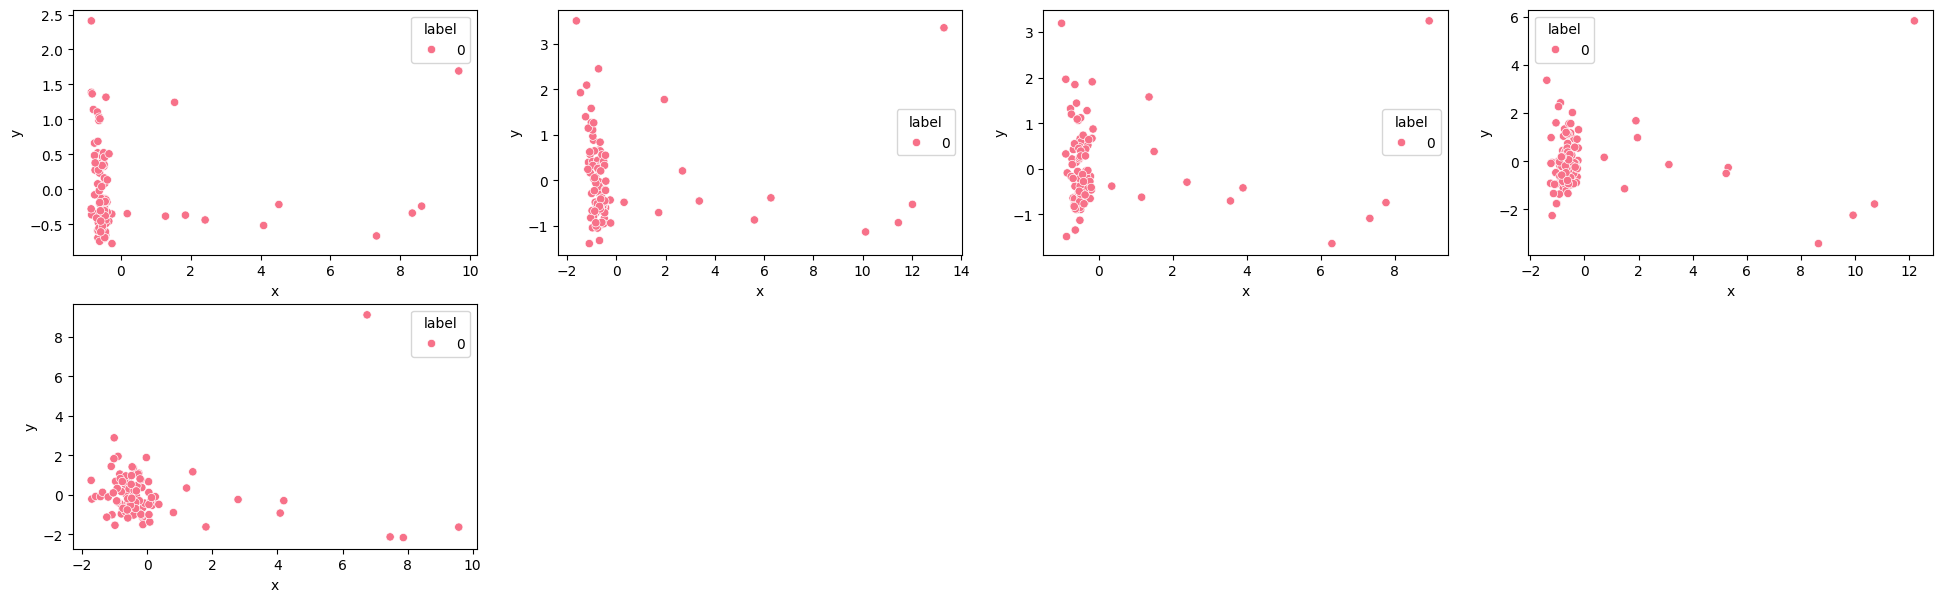

In [ ]:
batch = get_batch_data_balanced(test_loader, device, 100)
model.eval()

with torch.no_grad():
  outputs = model(**batch)
  hidden_states = outputs.hidden_states
  masks = batch['attention_mask'].cpu()
  labels = batch['labels'].cpu()

print(len(hidden_states))
# Since we have 4 hidden layers defined by the task.
layers_to_visualize = [0, 1, 2, 3, 4]
pca = PCA(n_components=2)
visualize_layerwise_embeddings(hidden_states, masks, labels, layers_to_visualize, pca)

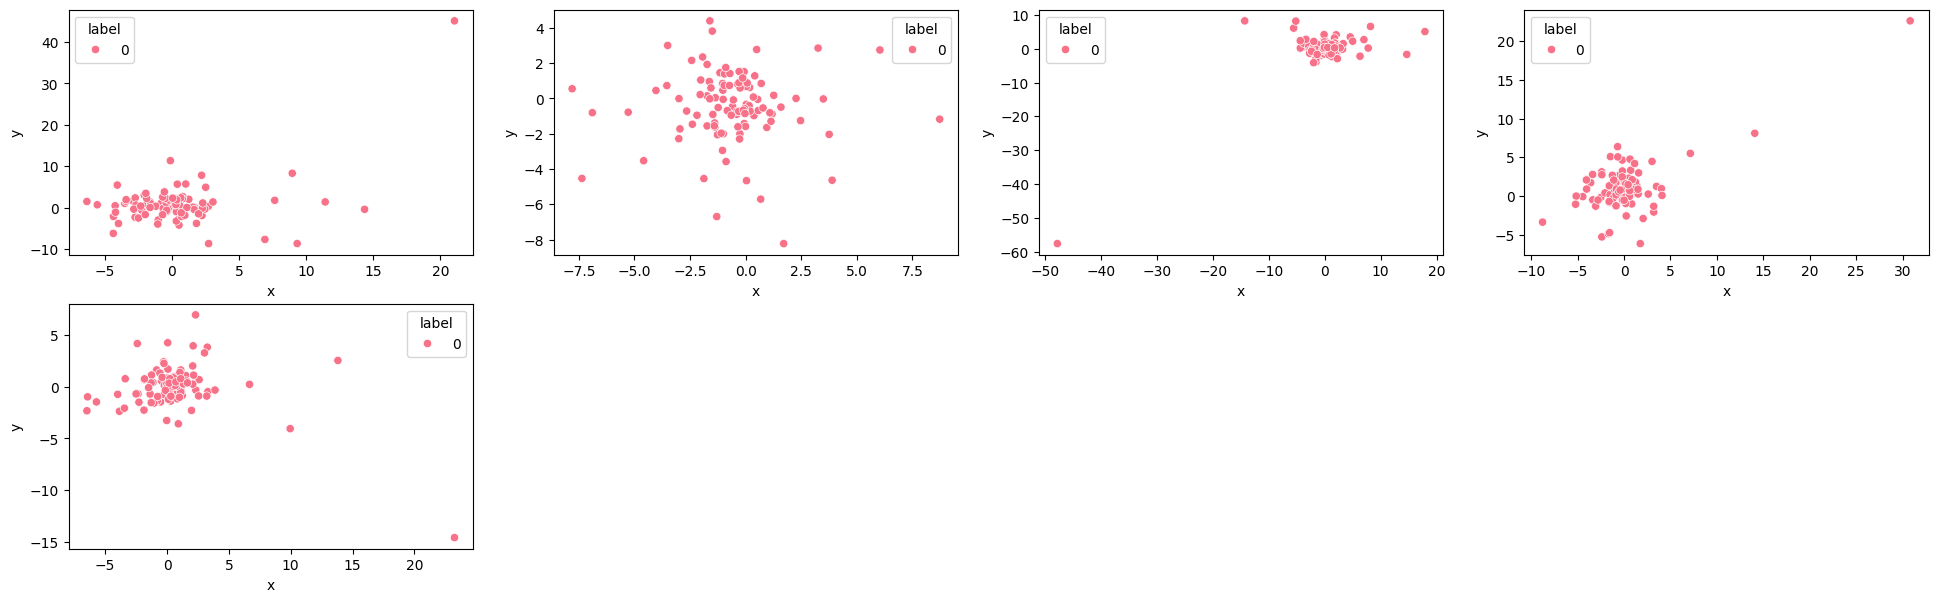

In [ ]:
layers_to_visualize = [0, 1, 2, 3, 4]
# Since batch size is low due to low memory usage by colab, we used
# perplexity 5 since it's the minimum recomended by the documentation
# of Sklearn
tsne = TSNE(n_components=2, perplexity=5, n_iter=250)

visualize_layerwise_embeddings(hidden_states, masks, labels, layers_to_visualize, tsne)

### Discussion of key points

- The fine tunning was able to improve the embedding visualization?


We don't know why it is getting only points that are negative reviews. But it seems that the fine tunning was able to improve the agglomeration of the negative review, since in the previous visualizations they were sparsed

## Deadline

Friday, June 28, 11:59 pm.

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- June 29, 11:59 pm : grade * 0.75
- June 30, 11:59 pm : grade * 0.5
- July 01, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English) or Google Colaboratory link (remember to share it!).

**This activity is NOT individual, it must be done in pairs (two-person group).**

Only one individual should deliver the notebook.